## RQ4: Analysis of User Engagement Through Behavioral Activity Metrics

To address this research question, we extracted a series of behavioral features from raw activity logs, such as the total number of activities, average weekly activity, number of active weeks, and the longest streak of consecutive weekly engagement. These features were designed to capture different aspects of user behavior, including intensity, consistency, and longevity of platform usage.
The resulting metrics provide a meaningful representation of student engagement patterns and form the basis for further analysis, including churn prediction and subgroup profiling.

### 1. Initialization and Feature Extraction

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Principal package imports
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy as sc

# Scikit-learn package imports
from sklearn import feature_extraction, model_selection
from sklearn.metrics import root_mean_squared_error, mean_squared_error, roc_auc_score

# PyBKT package imports
import random
old_randint = random.randint
random.randint = lambda a, b: old_randint(a, int(b))
from pyBKT.models import Model
random.randint = old_randint

In [2]:
import pandas as pd
import numpy as np

# read files
activity_df = pd.read_csv("/home/mlbd-project/updated_data/activity.csv")
students_df = pd.read_csv("/home/mlbd-project/updated_data/students.csv")

# Convert datetime format
activity_df["activity_started_dt"] = pd.to_datetime(activity_df["activity_started"], unit="s")
students_df["creation_time_dt"] = pd.to_datetime(students_df["creation_time"], unit="s")

# cutoff
cutoff_date = activity_df["activity_started_dt"].max()


activity_df["week_number"] = ((activity_df["activity_started_dt"] - activity_df["activity_started_dt"].min()).dt.days // 7)

# active_weeks
active_weeks = activity_df.groupby("user_id")["week_number"].nunique().reset_index(name="active_weeks")

# longest_streak_weeks
def longest_streak(weeks):
    weeks = sorted(set(weeks))
    max_streak = streak = 1 if weeks else 0
    for i in range(1, len(weeks)):
        if weeks[i] == weeks[i-1] + 1:
            streak += 1
            max_streak = max(max_streak, streak)
        else:
            streak = 1
    return max_streak

streaks = activity_df.groupby("user_id")["week_number"].apply(longest_streak).reset_index(name="longest_streak_weeks")

# avg_weekly_activity
total_acts = activity_df.groupby("user_id").size().reset_index(name="total_activities")
avg_week = total_acts.merge(active_weeks, on="user_id", how="left")
avg_week["avg_weekly_activity"] = avg_week["total_activities"] / avg_week["active_weeks"].replace(0, 1)

# days_between_first_and_last
activity_summary = activity_df.groupby("user_id").agg(
    first_activity=("activity_started_dt", "min"),
    last_activity=("activity_started_dt", "max")
).reset_index()
activity_summary["days_between_first_and_last"] = (activity_summary["last_activity"] - activity_summary["first_activity"]).dt.days

# std_days_between_activities
activity_df_sorted = activity_df.sort_values(["user_id", "activity_started_dt"])
activity_df_sorted["prev_activity"] = activity_df_sorted.groupby("user_id")["activity_started_dt"].shift()
activity_df_sorted["days_between"] = (activity_df_sorted["activity_started_dt"] - activity_df_sorted["prev_activity"]).dt.days
std_gap = activity_df_sorted.groupby("user_id")["days_between"].std().reset_index(name="std_days_between_activities")

# combine them
model_df = activity_summary.merge(total_acts, on="user_id", how="left") \
                           .merge(avg_week[["user_id", "avg_weekly_activity"]], on="user_id", how="left") \
                           .merge(active_weeks, on="user_id", how="left") \
                           .merge(streaks, on="user_id", how="left") \
                           .merge(std_gap, on="user_id", how="left")

# additional features
model_df["days_since_last_activity"] = (cutoff_date - model_df["last_activity"]).dt.days
model_df["days_since_first_activity"] = (cutoff_date - model_df["first_activity"]).dt.days
model_df["first_activity_ts"] = model_df["first_activity"].astype("int64") // 10**9

# Churn label
model_df["churn"] = (model_df["days_since_last_activity"] > 28).astype(int)

model_df = model_df.fillna(0)

display(model_df.head())

,user_id,first_activity,last_activity,days_between_first_and_last,total_activities,avg_weekly_activity,active_weeks,longest_streak_weeks,std_days_between_activities,days_since_last_activity,days_since_first_activity,first_activity_ts,churn
0,1,2024-10-26 07:03:04,2025-02-24 06:41:50,120,75,5.76923,13,5,3.91423,11,132,1729926184,0
1,2,2024-07-12 08:49:40,2024-07-12 08:49:40,0,1,1.00000,1,1,0.00000,238,238,1720774180,1
2,4,2024-10-26 07:01:22,2025-01-25 07:48:20,91,70,11.66667,6,4,6.24298,41,132,1729926082,1
3,5,2024-10-26 07:01:37,2024-12-07 07:57:10,42,10,5.00000,2,1,14.00000,90,132,1729926097,1
4,6,2024-10-26 07:01:11,2025-02-16 08:59:06,113,142,11.83333,12,8,2.79423,19,132,1729926071,0


In [3]:
model_df = model_df[model_df["first_activity"] >= pd.Timestamp("2024-03-15 06:41:50")]

In [4]:
display(cutoff_date)
display(model_df.shape)

Timestamp('2025-03-07 14:55:42')

(1109, 13)

#### Data Exploration

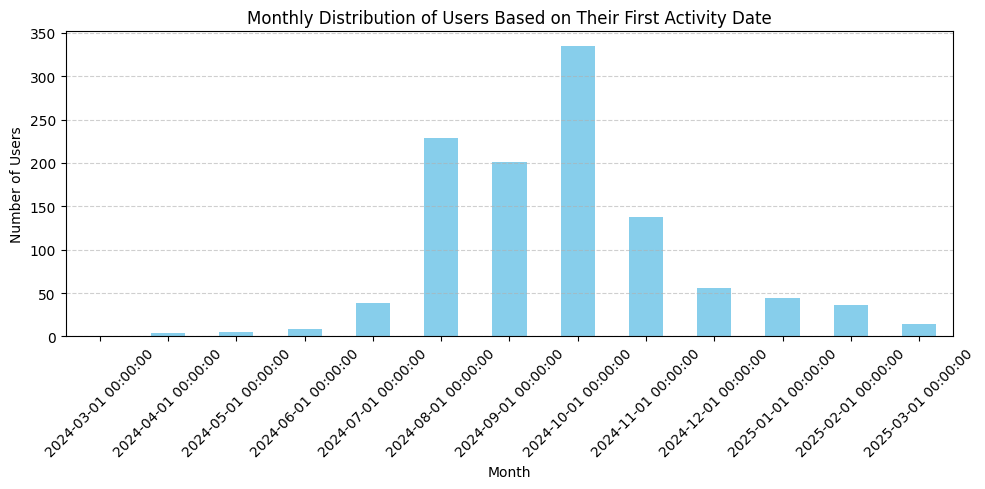

In [5]:
import matplotlib.pyplot as plt

# Group by month: count of users whose first recorded activity occurred in each respective month
monthly_counts = model_df["first_activity"].dt.to_period("M").value_counts().sort_index()
monthly_counts.index = monthly_counts.index.to_timestamp()

# Barplot
plt.figure(figsize=(10, 5))
monthly_counts.plot(kind="bar", color="skyblue")
plt.title("Monthly Distribution of Users Based on Their First Activity Date")
plt.xlabel("Month")
plt.ylabel("Number of Users")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

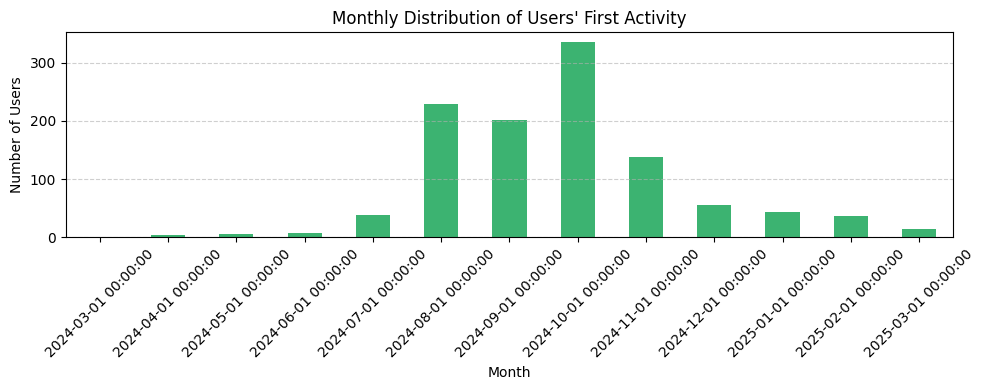

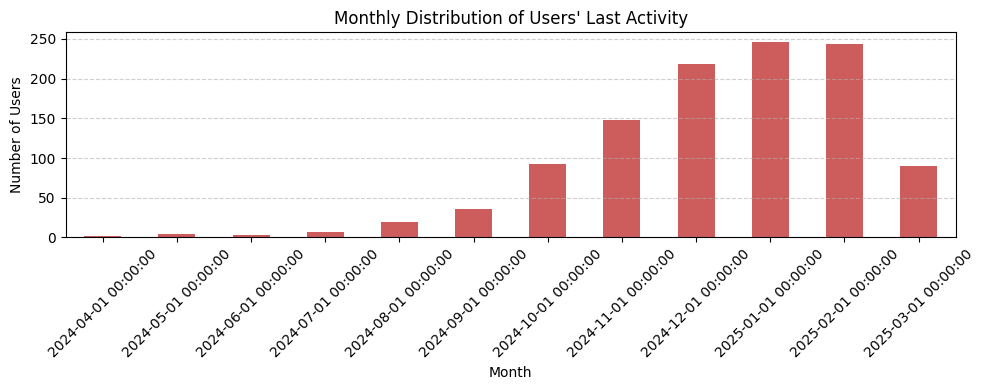

In [6]:
import matplotlib.pyplot as plt

# Ensure datetime type (optional safety check)
model_df["first_activity"] = pd.to_datetime(model_df["first_activity"])
model_df["last_activity"] = pd.to_datetime(model_df["last_activity"])

# First activity monthly counts
first_monthly = model_df["first_activity"].dt.to_period("M").value_counts().sort_index()
first_monthly.index = first_monthly.index.to_timestamp()

# Last activity monthly counts
last_monthly = model_df["last_activity"].dt.to_period("M").value_counts().sort_index()
last_monthly.index = last_monthly.index.to_timestamp()

# Plot First Activity
plt.figure(figsize=(10, 4))
first_monthly.plot(kind="bar", color="mediumseagreen")
plt.title("Monthly Distribution of Users' First Activity")
plt.xlabel("Month")
plt.ylabel("Number of Users")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# Plot Last Activity
plt.figure(figsize=(10, 4))
last_monthly.plot(kind="bar", color="indianred")
plt.title("Monthly Distribution of Users' Last Activity")
plt.xlabel("Month")
plt.ylabel("Number of Users")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

### 2. Model and Evaluation

In [12]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings("ignore")

# feature selection
feature_cols = [
    "total_activities", "first_activity_ts", "active_weeks",
    "longest_streak_weeks", "avg_weekly_activity",
 "std_days_between_activities"
]
# "days_between_first_and_last"
X = model_df[feature_cols]
y = model_df["churn"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model and training
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)

# guess
y_pred = model.predict(X_test)

# Performance mtrics
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.75      0.79        61
           1       0.91      0.94      0.93       161

    accuracy                           0.89       222
   macro avg       0.87      0.85      0.86       222
weighted avg       0.89      0.89      0.89       222

Confusion Matrix:
[[ 46  15]
 [  9 152]]


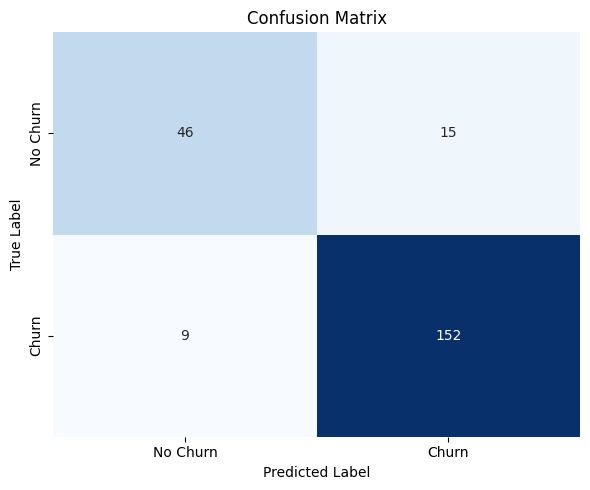

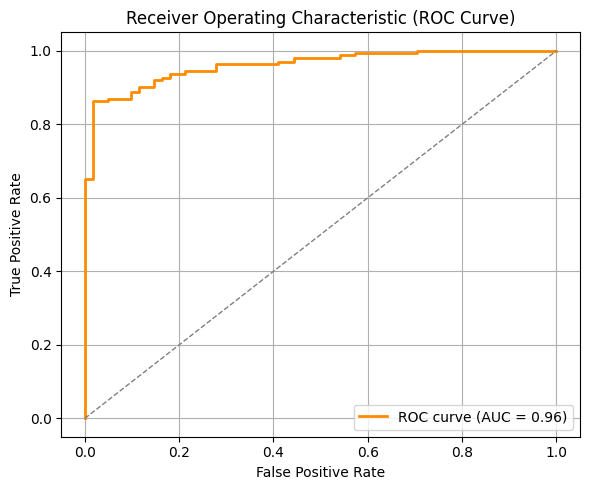

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# === 1. Confusion Matrix Plot ===
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["No Churn", "Churn"],
            yticklabels=["No Churn", "Churn"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# === 2. ROC Curve Plot ===
y_proba = model.predict_proba(X_test)[:, 1]  # probabilities for churn class
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC Curve)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

### 3. Plots

SHAP Feature Importance (Bar Plot)


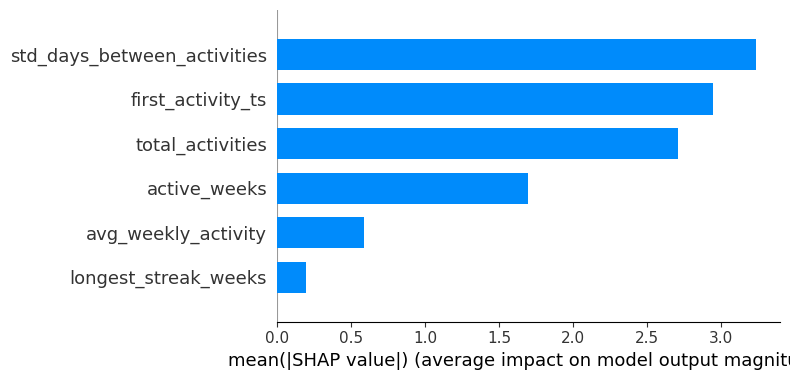

SHAP Summary Plot – Feature Effect Distribution


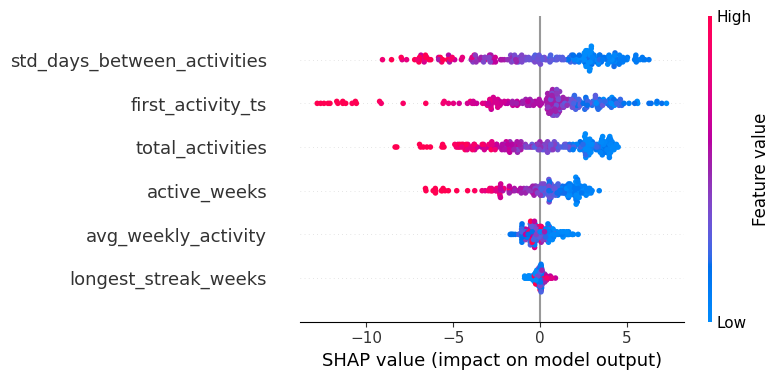

SHAP Force Plot – Individual Prediction Explanation


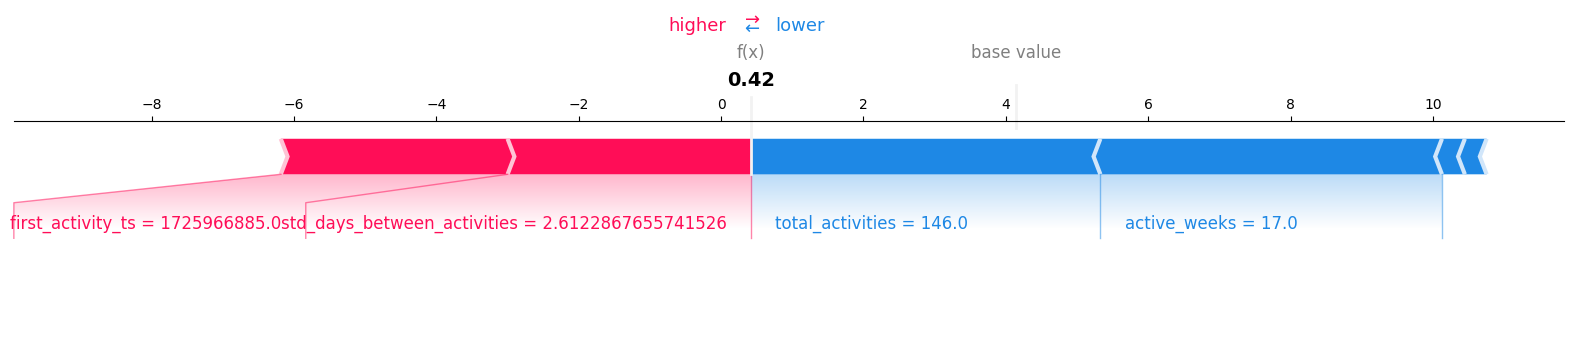

In [9]:
import shap
import matplotlib.pyplot as plt

# 1. Create SHAP explainer
explainer = shap.Explainer(model, X_train)

# 2. Compute SHAP values (disable additivity check for numerical stability)
shap_values = explainer(X_test, check_additivity=False)

# 3. Bar chart of feature importance
print("SHAP Feature Importance (Bar Plot)")
shap.summary_plot(shap_values, X_test, plot_type="bar")

# 4. Summary plot showing feature effects across all predictions
print("SHAP Summary Plot – Feature Effect Distribution")
shap.summary_plot(shap_values, X_test)

# 5. Force plot for a single student’s prediction (example: first test sample)
print("SHAP Force Plot – Individual Prediction Explanation")
shap.plots.force(shap_values[0], matplotlib=True)


### Additional
To improve the readability of the SHAP visualizations, feature names were reformatted into more descriptive and human-readable labels. This adjustment allows for clearer interpretation of the plots and enhances their effectiveness for presentation and analysis purposes.

SHAP Feature Importance (Bar Plot)


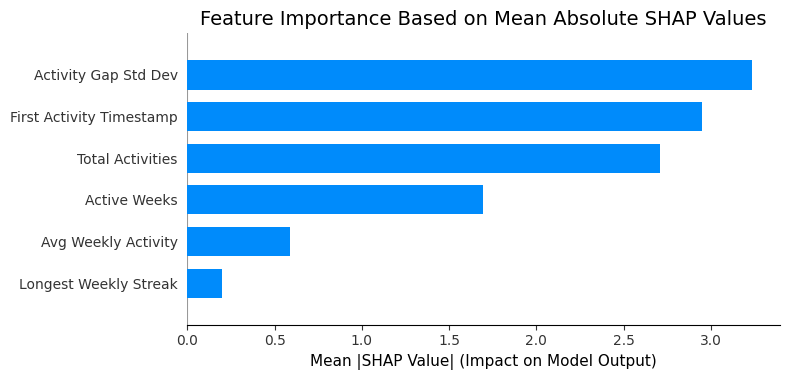

SHAP Feature Effects (Dot Plot)


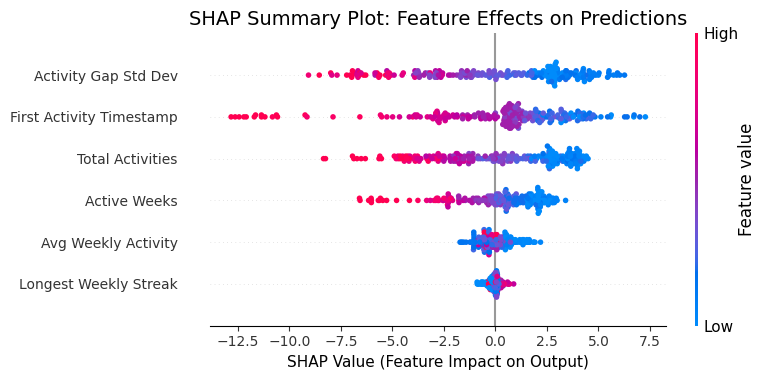

SHAP Force Plot – Individual Prediction Explanation


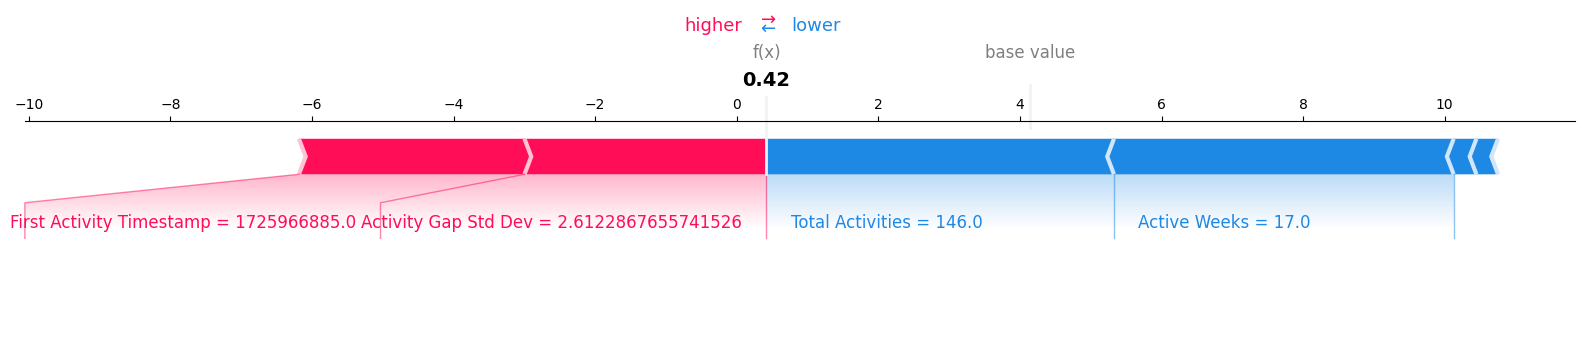

In [10]:
import shap
import matplotlib.pyplot as plt

# 1. Custom readable feature names for visualization
rename_map = {
    "total_activities": "Total Activities",
    "avg_weekly_activity": "Avg Weekly Activity",
    "active_weeks": "Active Weeks",
    "longest_streak_weeks": "Longest Weekly Streak",
    "std_days_between_activities": "Activity Gap Std Dev",
    "days_since_last_activity": "Days Since Last Activity",
    "days_since_first_activity": "Days Since First Activity",
    "first_activity_ts": "First Activity Timestamp",
    "churn": "Churn"
}

# 2. Rename feature columns for better readability in plots
X_test_pretty = X_test.rename(columns=rename_map)

# 3. Create SHAP explainer
explainer = shap.Explainer(model, X_train)

# 4. Compute SHAP values
shap_values = explainer(X_test, check_additivity=False)
shap_values.feature_names = X_test_pretty.columns.tolist()

# 5. SHAP bar plot: average absolute impact of each feature
print("SHAP Feature Importance (Bar Plot)")
shap.summary_plot(shap_values, X_test_pretty, plot_type="bar", show=False)
plt.title("Feature Importance Based on Mean Absolute SHAP Values", fontsize=14)
plt.xlabel("Mean |SHAP Value| (Impact on Model Output)", fontsize=11)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# 6. SHAP dot plot: distribution of feature impacts per sample
print("SHAP Feature Effects (Dot Plot)")
shap.summary_plot(shap_values, X_test_pretty, show=False)
plt.title("SHAP Summary Plot: Feature Effects on Predictions", fontsize=14)
plt.xlabel("SHAP Value (Feature Impact on Output)", fontsize=11)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# 7. Force plot for an individual prediction (first test sample)
print("SHAP Force Plot – Individual Prediction Explanation")
shap.plots.force(shap_values[0], matplotlib=True)